# 🧪 Custom Random Forest Classification

In this notebook, we implement random forest **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `RandomForestClassifier` and `DecisionTreeClassifier` models.

### ⚙️ Importing Libraries & Environment Setup

In [79]:
from math import ceil
from typing import Any, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [80]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [81]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        evaluations.loc[:, name] = [accuracy, precision, recall, f1, roc_auc]

    return evaluations.astype(float)

In [82]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [83]:
def plot_decision_tree_boundaries(
    models: dict[str, Any],
    X_train: NDArray[np.float64],
    y_train: NDArray[np.float64],
    n_cols: int = 2,
) -> None:
    """Visualize decision boundaries of trained decision tree models.

    Args:
        models (dict[str, Any]): Dictionary of trained models with `.predict` method.
        X_train (NDArray[np.float64]): Training features of shape (n_samples, 2).
        y_train (NDArray[np.float64]): Training labels of shape (n_samples,).
        n_cols (int): Number of columns in subplot grid.
    """
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    n_models = len(models)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, model) in zip(axes, models.items(), strict=False):
        Z = model.predict(grid).reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
        sns.scatterplot(
            x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="Set1", alpha=0.5, ax=ax
        )
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [84]:
# Generate dataset
X, y = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=0)

In [85]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [86]:
class MyRandomForestClassifier:
    """Random Forest classifier using ensemble of decision trees.

    Builds multiple decision trees using bootstrapped samples and random subsets of
    features to reduce variance and improve generalization. Final predictions are
    determined by majority voting.

    Attributes:
        n_estimators (int): Number of trees in the ensemble.
        criterion (str): Splitting criterion ("gini", "entropy", or "log_loss").
        max_depth (int | None): Maximum depth allowed for each tree.
        min_samples_split (int | float): Minimum samples required to split an
            internal node.
        min_samples_leaf (int | float): Minimum samples required to be present at
            a leaf node.
        min_weight_fraction_leaf (float): Minimum fraction of samples required at
            a leaf node.
        max_features (int | float | str | None): Number or proportion of features
            to consider when looking for best splits.
        max_leaf_nodes (int | None): Maximum number of leaf nodes per tree.
        min_impurity_decrease (float): Minimum impurity decrease required
            to make a split.
        bootstrap (bool): Whether samples are drawn with replacement.
        class_weight (dict | str | None): Weights associated with classes.
        ccp_alpha (float): Complexity parameter used for Minimal Cost-Complexity
            Pruning.
        max_samples (int | float | None): Number or fraction of samples to draw
            for each tree.
        rng (RandomGenerator): NumpPy random generator for reproducibility.
        trees (list[DecisionTreeClassifier]): Trained decision tree estimators.
    """

    def __init__(
        self,
        n_estimators: int = 100,
        criterion: Literal["gini", "entropy", "log_loss"] = "gini",
        max_depth: int | None = None,
        min_samples_split: int | float = 2,
        min_samples_leaf: int | float = 1,
        min_weight_fraction_leaf: float = 0.0,
        max_features: int | float | Literal["sqrt", "log2"] | None = "sqrt",
        max_leaf_nodes: int | None = None,
        min_impurity_decrease: float = 0.0,
        bootstrap: bool = True,
        random_state: int | None = None,
        class_weight: dict | Literal["balanced", "balanced_subsample"] | None = None,
        ccp_alpha: float = 0.0,
        max_samples: int | float | None = None,
    ) -> None:
        """Initialize the Random Forest classifier with hyperparameters.

        Args:
            n_estimators (int): Number of trees in the forest.
            criterion (Literal["gini", "entropy", "log_loss"]): Function to measure
                split quality.
            max_depth (int | None): Maximum depth of each tree.
            min_samples_split (int | float): Minimum samples needed to split a node.
            min_samples_leaf (int | float): Minimum samples needed in a leaf node.
            min_weight_fraction_leaf (float): Minimum weighted fraction needed in a leaf.
            max_features (int | float | Literal["sqrt", "log2"] | None): Number,
                fraction, or method to select features for splits.
            max_leaf_nodes (int | None): Maximum number of leaf nodes per tree.
            min_impurity_decrease (float): Threshold for impurity reduction to
                split nodes.
            bootstrap (bool): Whether to use bootstrap sampling.
            random_state (int | None): Seed for reproducibility.
            class_weight (dict | Literal["balanced", "balanced_subsample"] | None):
                Class weight adjustment for handling imbalanced data.
            ccp_alpha (float): Complexity parameter for pruning.
            max_samples (int | float | None): Number or fraction of samples per tree.
        """
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.class_weight = class_weight
        self.ccp_alpha = ccp_alpha
        self.max_samples = max_samples

        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.trees: list[DecisionTreeClassifier] = []

    def _get_indices(self, n_indices: int, max_indices: float) -> NDArray[np.int64]:
        """Generate random indices for sampling.

        If `max_indices` <= 1, treated as fraction of `n_indices`.
        Otherwise treated as absolute number.

        Args:
            n_indices (int): Total number of elements to sample from.
            max_indices (float): Fraction or count of elements to sample.

        Returns:
            NDArray[np.int64]: Randomly sampled indices.
        """
        if max_indices <= 1:
            size = int(n_indices * max_indices)
        else:
            size = int(max_indices)

        return self.rng.choice(n_indices, size=size, replace=self.bootstrap)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Train the Random Forest classifier.

        Each tree is trained on a bootstrapped sample of the dataset,
        with a random subset of features considered at each split.

        Args:
            X (NDArray[np.float64]): Training data of shape (n_samples, n_features).
            y (NDArray[np.int64]): Target labels of shape (n_samples,).
        """
        n_samples = X.shape[0]
        if self.max_samples is None:
            self.max_samples = n_samples

        self.trees.clear()

        for _ in range(self.n_estimators):
            sample_indices = self._get_indices(n_samples, self.max_samples)
            X_sample, y_sample = X[sample_indices], y[sample_indices]

            tree = DecisionTreeClassifier(
                criterion=self.criterion,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                max_features=self.max_features,
                max_leaf_nodes=self.max_leaf_nodes,
                min_impurity_decrease=self.min_impurity_decrease,
                class_weight=self.class_weight,
                ccp_alpha=self.ccp_alpha,
                random_state=self.rng.integers(1_000_000),
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict class labels for samples in X.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted class labels.
        """
        predictions = np.array([tree.predict(X) for tree in self.trees])
        maj_vote = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), axis=0, arr=predictions
        )
        return maj_vote.astype(int)

### 🏋️‍♂️ Model Training

In [87]:
# Scikit-learn decision tree classifier model
sklearn_model_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
sklearn_model_tree.fit(X_train, y_train)

# Scikit-learn random forest classifier model
sklearn_model = RandomForestClassifier(
    n_estimators=20, max_depth=3, bootstrap=True, random_state=42
)
sklearn_model.fit(X_train, y_train)

# My random forest classifier model
my_model = MyRandomForestClassifier(
    n_estimators=20, max_depth=3, bootstrap=True, random_state=42
)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [88]:
predictions = {
    "scikit-learn_tree": sklearn_model_tree.predict(X_test),
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

models = {
    "scikit-learn_tree": sklearn_model_tree,
    "scikit-learn": sklearn_model,
    "my": my_model,
}

In [89]:
evaluate_classification_models(predictions, y_test)

,scikit-learn_tree,scikit-learn,my
Accuracy,0.866667,1.0,1.0
Precision,0.741935,1.0,1.0
Recall,1.000000,1.0,1.0
F1-score,0.851852,1.0,1.0
ROC AUC,0.891892,1.0,1.0


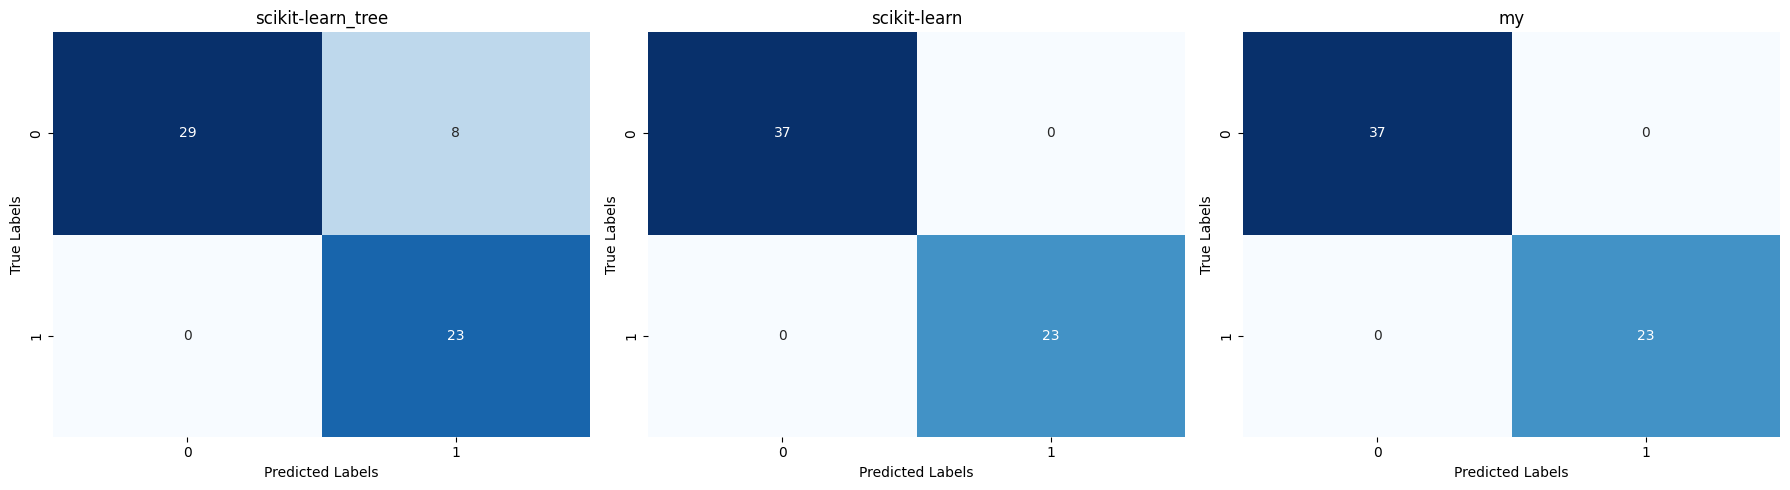

In [90]:
plot_confusion_matrices(predictions, y_test, n_cols=3)

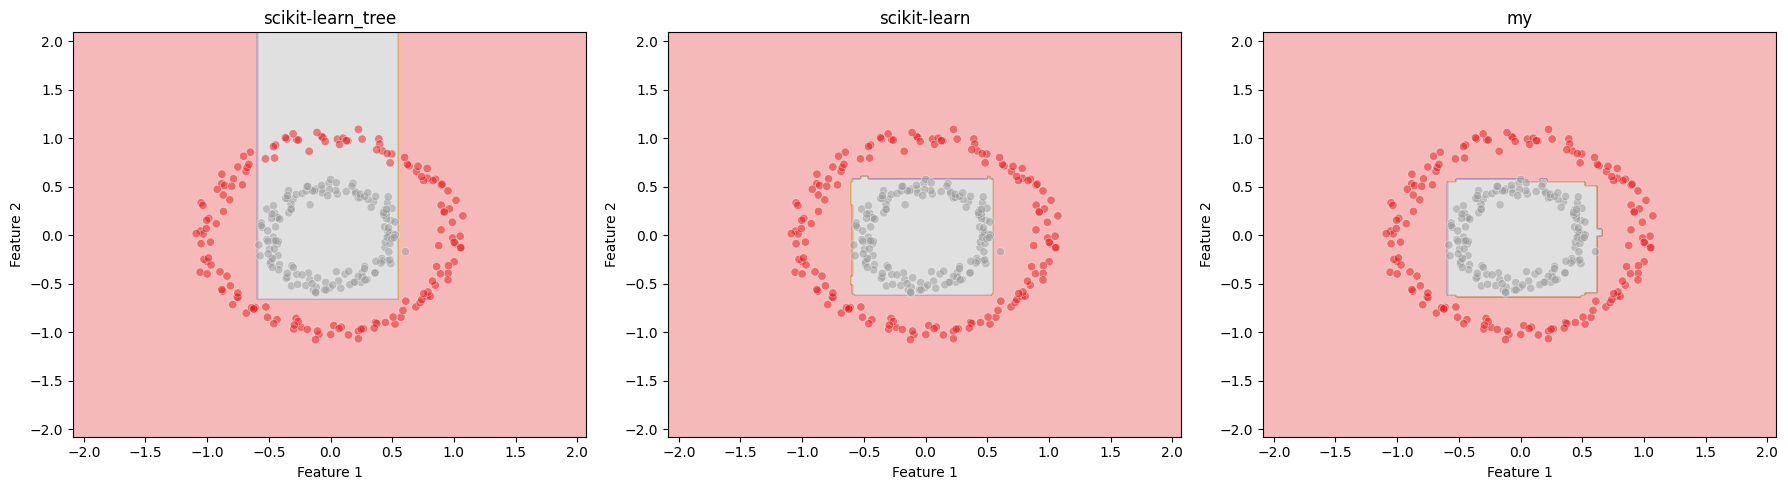

In [91]:
plot_decision_tree_boundaries(models, X, y, n_cols=3)